In [4]:
# Random testing block
from datetime import datetime
date = datetime(2023, 6, 13).strftime("%Y-%m-%d")
date

'2023-06-13'

# Check existing similarities

In [1]:
# Get player names
from database_workers.Neo4j_Player_Worker import Player_Worker
player_worker = Player_Worker()
player_names = player_worker.get_player_names()
player_names = [record['name'] for record in player_names] # Extract the values into a list
player_names

['Adrian Mannarino',
 'Alec Deckers',
 'Alex de Minaur',
 'Alexander Bublik',
 'Alexei Popyrin',
 'Aliaksandra Sasnovich',
 'Alison Riske-Amritraj',
 'Ana Konjuh',
 'Anna Blinkova',
 'Anna-Lena Friedsam',
 'Arthur Fils',
 'Arthur Rinderknech',
 'Ashlyn Krueger',
 'Belinda Bencic',
 'Bernabe Zapata Miralles',
 'Bianca Andreescu',
 'Borna Coric',
 'Botic van de Zandschulp',
 'Brandon Nakashima',
 'Carol Zhao',
 'Caty Mcnally',
 'Celine Naef',
 'Coco Vandeweghe',
 'Corentin Moutet',
 'Dalma Galfi',
 'Daniil Medvedev',
 'David Goffin',
 'Ekaterina Alexandrova',
 'Elina Svitolina',
 'Elise Mertens',
 'Emil Ruusuvuori',
 'Emina Bektas',
 'Eva Lys',
 'Evgeniya Rodina',
 'Felix Auger-Aliassime',
 'Gijs Brouwer',
 'Greet Minnen',
 'Ilya Ivashka',
 'Jason Kubler',
 'Jessika Ponchet',
 'Jordan Thompson',
 'Karolina Muchova',
 'Katie Volynets',
 'Kimberly Birrell',
 'Lesley Pattinama Kerkhove',
 'Liudmila Samsonova',
 'Mackenzie McDonald',
 'Mai Hontama',
 'Marie Bouzkova',
 'Marin Cilic',
 'Max P

In [2]:
# Make similarity dfs
from database_workers.Recommender import Recommender
recommender = Recommender(player_names)
recommender.create_similarity_dfs()
similarity_dfs = recommender.similarity_dfs
similarity_dfs

{'all':                     Adrian Mannarino Alec Deckers Alex de Minaur   
 Adrian Mannarino                 NaN          NaN       0.320022  \
 Alec Deckers                     NaN          NaN            NaN   
 Alex de Minaur              0.320022          NaN            NaN   
 Alexander Bublik            0.243934          NaN       0.319458   
 Alexei Popyrin                   NaN          NaN            NaN   
 ...                              ...          ...            ...   
 Viktoria Hruncakova              NaN          NaN            NaN   
 Yanina Wickmayer                 NaN          NaN            NaN   
 Ysaline Bonaventure         0.368201          NaN       0.341813   
 Yue Yuan                         NaN          NaN            NaN   
 Zizou Bergs                      NaN          NaN            NaN   
 
                     Alexander Bublik Alexei Popyrin Aliaksandra Sasnovich   
 Adrian Mannarino            0.243934            NaN              0.247671  \
 Alec D

In [3]:
similarity_dfs['all']
# Find column name which has only NaN values
len(similarity_dfs['all'].columns[similarity_dfs['all'].isna().all()])

36

**There are 36 players with no similarity edges!!**

In [4]:
recs = recommender.recommend_individual(['Adrian Mannarino', 'Ysaline Bonaventure'], 'all')
recs

,rec_player,player,similarity
71,Tim van Rijthoven,Ysaline Bonaventure,0.565159
73,Ugo Humbert,Ysaline Bonaventure,0.563451
58,Petra Martic,Adrian Mannarino,0.45589
56,Pablo Carreno Busta,Adrian Mannarino,0.449263


In [5]:
# Get highest similarity score where level_1 is Adrian Mannarino
recs[recs['player'] == 'Adrian Mannarino'].iloc[0]

rec_player        Petra Martic
player        Adrian Mannarino
similarity             0.45589
Name: 58, dtype: object

# Check match stuff

In [1]:
from database_workers.Neo4j_Player_Worker import Player_Worker
player_worker = Player_Worker()
player_names = player_worker.get_player_names()
player_worker.close()
player_names = [record['name'] for record in player_names] # Extract the values into a list
player_names

from database_workers.Recommender import Recommender
recommender = Recommender(player_names)
recommender.create_similarity_dfs()
recommender.recommend_matches(user_id= "2ynkTuAVPVPDKEMqj8apjVboOqo1")

['Elise Mertens', 'Marie Bouzkova', 'Ugo Humbert']
   similarity similarity_type recommendation_type        player_name   
0    0.660721             all              player   Rebecca Peterson  \
1    0.725794             all              player     Belinda Bencic   
2    0.638898             all              player  Tim van Rijthoven   
3    0.615495             all              player    Elina Svitolina   
4    0.678793             all              player       Petra Martic   
5    0.610831             all              player        Marin Cilic   

  liked_player_name  
0    Marie Bouzkova  
1     Elise Mertens  
2       Ugo Humbert  
3     Elise Mertens  
4    Marie Bouzkova  
5       Ugo Humbert  


,match_name,match_date,match_time,match_location,priority
0,Pablo Carreno Busta vs Botic van de Zandschulp,2023-06-10,15:00,Hall 2,0.559220
1,Daniil Medvedev vs Borna Coric,2023-06-10,10:00,Hall 1,0.524495


In [2]:
from datetime import datetime

# Call the recommend_match function with the formatted dates


UnboundLocalError: local variable 'formatted_days' referenced before assignment

In [4]:
# Get matches
from database_workers.Neo4j_Player_Worker import Player_Worker
player_worker = Player_Worker()
matches = player_worker.get_all_matches()
player_worker.close()
matches

[{'match_name': 'Daniil Medvedev vs Borna Coric',
  'match_date': '2023-06-10',
  'match_time': '10:00',
  'match_location': 'Hall 1'},
 {'match_name': 'Pablo Carreno Busta vs Botic van de Zandschulp',
  'match_date': '2023-06-10',
  'match_time': '15:00',
  'match_location': 'Hall 2'}]

In [1]:
from database_workers.Neo4j_User_Worker import User_Worker
from database_workers.Neo4j_Player_Worker import Player_Worker
from datetime import datetime

# Initialize the workers
user_worker = User_Worker()
player_worker = Player_Worker()

# Get the user's days and format them to "yyyy-mm-dd"
user = "2ynkTuAVPVPDKEMqj8apjVboOqo1"
days = user_worker.get_user_settings(user)['days']
formatted_days = [datetime.strptime(day, "%d/%m/%Y").strftime("%Y-%m-%d") for day in days]

# Get all matches
matches = player_worker.get_all_matches()

# Close the workers
user_worker.close()
player_worker.close()

# Extract the dates from the matches
match_dates = [match['match_date'] for match in matches]

# Find the intersection of the user's days and the match dates
intersection = list(set(formatted_days) & set(match_dates))

print("User's days: ", formatted_days)
print("Match dates: ", match_dates)
print("Intersection: ", intersection)

# Get the matches which are on the intersection of the user's days and the match dates
matches = [match for match in matches if match['match_date'] in intersection]
matches


NameError: name 'formatted_days' is not defined

In [5]:
# Upload all matches to the database
# from database_workers.item_handling.match_editor import MatchEditor
# match_editor = MatchEditor("./data/Matches.xlsx")
# match_editor.upload_matches_to_db()

# Test mail

In [5]:
# import csv, smtplib, ssl
# name = "Testname"
# grade = "Testgrade"

# message = """Subject: Your grade

# Hi {name}, your grade is {grade}"""

# from_address = "jads@recommendersystems.nl"
# password = "Tennis4Jads"

# context = ssl.create_default_context()
# with smtplib.SMTP_SSL("smtp.versatel.nl", 465, context=context) as server:
#     server.login(from_address, password)
#     with open("contacts_file.csv") as file:
#         # reader = csv.reader(file)
#         # next(reader)  # Skip header row
#         # for name, email, grade in reader:
#         #     server.sendmail(
#         #         from_address,
#         #         email,
#         #         message.format(name=name,grade=grade),
#         #     )
#         server.sendmail(
#             from_address,
#             "asafkedem97@gmail.com",
#             message.format(name=name,grade=grade)
#         )


import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

name = "Testname"
grade = "Testgrade"
# subject = "Your grade"

from_address = "jads@recommendersystems.nl"
password = "Tennis4Jads"
to_address = "asafkedem97@gmail.com"

# Create message container - the correct MIME type is multipart/alternative.
msg = MIMEMultipart('alternative')
msg['Subject'] = "Your grade"
msg['From'] = from_address
msg['To'] = to_address
text="Test"
# text = "Hi {name}, your grade is {grade}".format(name=name, grade=grade)
# Record the MIME types of both parts - text/plain and text/html.
part1 = MIMEText(text, 'plain')

# Attach parts into message container.
msg.attach(part1)

try:
    server = smtplib.SMTP('mail212.zonnet.nl', 587)
    server.ehlo()
    server.starttls()
    server.login(from_address, password)
    server.sendmail(from_address, to_address, msg.as_string())
    server.quit()

    print('Email sent!')
except Exception as e:
    print('Something went wrong...', e)

Email sent!


# Play with tag categories

In [ ]:
import pandas as pd
tag_category_df = pd.read_excel("./data/Tag_Categories.xlsx")
tag_category_df['Category'].unique()

array(['Blank', 'Composed', 'Offensive play', 'Physical', 'Ignore',
       'Mental strength', 'Tactical play', 'Competitive',
       'Consistent play', 'Defensive play', 'Emotionally Expressive',
       'Outgoing personality', 'Unique', 'Net play'], dtype=object)

In [2]:
# How much of each category is present? Count their values
tag_category_df['Category'].value_counts()

Category
Offensive play            12
Physical                  11
Composed                  10
Mental strength           10
Ignore                     8
Competitive                8
Tactical play              7
Outgoing personality       6
Defensive play             3
Unique                     3
Consistent play            2
Net play                   2
Blank                      1
Emotionally Expressive     1
Name: count, dtype: int64

# Add new player and match data

In [1]:
# Upload new players
from database_workers.item_handling.player_editor import PlayerEditor
player_editor = PlayerEditor(personal_data_source="./data/Competitors.xlsx")
player_editor.upload_players_with_personal_data()

100%|██████████| 115/115 [00:00<00:00, 849.12it/s]


# Upload match data

In [1]:
from database_workers.item_handling.match_editor import MatchEditor
match_editor = MatchEditor(match_data="./data/Matches.xlsx")
match_editor.upload_matches_to_db()

# Create similarities

In [1]:
# Create similarity relations
# TODO: change parameters? Cri
from database_workers.Neo4j_Similarity_Worker import Similarity_Worker
similarity_worker = Similarity_Worker()
similarity_worker.create_numeric_similarities()
similarity_worker.create_bow_vectors()
similarity_worker.create_categorical_vectors()
similarity_worker.create_categorical_similarities()
similarity_worker.create_weighted_similarities()
similarity_worker.close()

Log values created for 0 players.
Scaled properties created for 115 players.
Euclidean similarities created for 1722 player pairs.


# Hacky way to download similarities from local db to upload to remote db

In [ ]:
# Find all similarities 

In [2]:
# USE LOCAL DB (.env)
from database_workers.Neo4j_Similarity_Worker import Similarity_Worker
similarity_worker = Similarity_Worker()
similarity_worker.download_all_similarities()
similarity_worker.close()

In [3]:
# # Test block
# import pandas as pd
# similarities_downloaded = pd.read_csv("./data/similarities.csv")
# similarities_downloaded.head()

# # Find rows where player1 or player2 is Adrian Mannarino and return those rows
# adrian = similarities_downloaded[(similarities_downloaded['player1'] == 'Adrian Mannarino') | (similarities_downloaded['player2'] == 'Adrian Mannarino')]
# adrian

# # Find rows in adrian where column "all" is not NaN and return those rows, sorted on the all column
# adrian[adrian['all'].notna()].sort_values(by=['all'], ascending=False)

In [1]:
# USE REMOTE DB (.env)
# Upload the similarities to the database
import pandas as pd
similarities_open = pd.read_csv("./data/similarities.csv")
# similarities_open
# similarities_open['all'].notnull().sum()
from database_workers.Neo4j_Similarity_Worker import Similarity_Worker
similarity_worker = Similarity_Worker()
similarity_worker.upload_similarities(similarities_open)
similarity_worker.close()

# Test recommender system

In [1]:
# Test recommender

# user_id="AN57y8tcIThEeqeo9Uq1s7pHzM03" # me server
# user_id="2ynkTuAVPVPDKEMqj8apjVboOqo1" # me local
user_id="ySL8pe5rdOg1osZ0pZl2v3I2Yzq1" # kees server
# user_id = "ud5lM9zjCTWeJQdIHDh5xoBUqoA2" # me server NEW

# get all player names
from database_workers.Neo4j_Player_Worker import Player_Worker
player_worker = Player_Worker()
player_names = player_worker.get_player_names()
player_names = [record['name'] for record in player_names] # Extract the values into a list
player_worker.close()

from database_workers.Recommender import Recommender
recommender = Recommender(player_names=player_names)
recommender.create_similarity_dfs()

# # Get the user's liked players
# from database_workers.Neo4j_Relation_Worker import Relation_Worker
# relation_worker = Relation_Worker()
# liked_players = relation_worker.get_liked_players(user_id=user_id)
# relation_worker.close()
# liked_players = [record['name'] for record in liked_players] # Extract the values into a list
# similarities = recommender.recommend_individual(player_names=liked_players, similarity_type="all", user_id=user_id)
# similarities
matches = recommender.recommend_matches(user_id=user_id)
matches

[{'match_name': 'Veronika Kudermetova vs Carol Zhao',
  'match_date': '2023-06-14',
  'match_time': 2,
  'match_location': 'Centre Court',
  'priority': 1.0,
  'recommendation_type': 'liked'},
 {'match_name': 'Borna Coric vs Mackenzie McDonald',
  'match_date': '2023-06-14',
  'match_time': 4,
  'match_location': 'Centre Court',
  'priority': 1.0,
  'recommendation_type': 'liked'},
 {'match_name': 'Polina Kudermetova vs Liudmila Samsonova',
  'match_date': '2023-06-14',
  'match_time': 4,
  'match_location': 'Court 1',
  'priority': 0.7015607600201139,
  'recommendation_type': 'recommended_by_player'},
 {'match_name': 'Rinky Hijikata vs Marc-Andrea Huesler',
  'match_date': '2023-06-14',
  'match_time': 2,
  'match_location': 'Court 1',
  'priority': 0.41247895569215276,
  'recommendation_type': 'similar_by_player'},
 {'match_name': 'Victoria Azarenka vs Ashlyn Krueger',
  'match_date': '2023-06-14',
  'match_time': 1,
  'match_location': 'Centre Court',
  'priority': 0.410791918128874

In [3]:
from database_workers.Neo4j_Player_Worker import Player_Worker
player_worker = Player_Worker()
matches = player_worker.get_all_matches()
player_worker.close()
len(matches)

38

In [3]:
# Get index at Adrian Mannarino where values are not NaN of recommender.similarity_dfs['all']

# columns = recommender.similarity_dfs['all'].loc['Adrian Mannarino'].notnull()
# columns = columns[columns==True]
# recommender.similarity_dfs['all'].loc['Adrian Mannarino'][columns.index]

Adrian Mannarino              0
Alec Deckers             0.1066
Alex de Minaur         0.515127
Alexander Bublik       0.319346
Alexei Popyrin         0.100504
                         ...   
Yanina Wickmayer         0.1066
Ysaline Bonaventure    0.459173
Yue Yuan                 0.1066
Zeynep Sonmez               0.0
Zizou Bergs            0.100504
Name: Adrian Mannarino, Length: 114, dtype: object

In [8]:
# check type of similarities['similarity]
type(similarities['similarity'][0])

# get unique values of similarity, sort ascending
# similarities['similarity'].unique()
similarities['similarity'].sort_values(ascending=False)

53     0.904534
63     0.858116
37     0.856349
91     0.836242
155      0.8044
         ...   
12     0.295016
205    0.190693
1      0.090909
211           0
60            0
Name: similarity, Length: 228, dtype: object

In [10]:
# # Check this is legit
# from database_workers.Neo4j_Similarity_Worker import Similarity_Worker
# similarity_worker = Similarity_Worker()
# similarity_worker.get_top_similarities(player_name="Daniil Medvedev", weighted_similarity_type="all", top_n=2, same_gender=True)
# similarity_worker.close()

# Track user event data

In [1]:
from database_workers.Neo4j_User_Worker import User_Worker
user_worker = User_Worker()
users = user_worker.get_unique_user_ids()
user_worker.close()
len(users)

42

In [2]:
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
events_all = []
for user in users:
    events_all.append(event_worker.get_user_events(user_id=user))
event_worker.close()

In [3]:
# An example of the events
events_all[0]

# Turn string timestamp into datetime object and put that back into the event object
# from datetime import datetime

# for events in events_all:
#     for event in events:
#         event['timestamp'] = datetime.strptime(event['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ')

# events_all[0]

[{'action': 'mounted',
  'page': 'App',
  'timestamp': '2023-06-04T17:17:59.625Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'Home',
  'timestamp': '2023-06-04T17:17:59.625Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'Home',
  'timestamp': '2023-06-04T17:20:03.003Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'Home',
  'timestamp': '2023-06-04T17:20:21.387Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'Home',
  'timestamp': '2023-06-04T17:20:55.916Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'close_player',
  'page': 'preferences',
  'timestamp': '2023-06-04T17:28:14.890Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'preferences',
  'timestamp': '2023-06-04T17:43:10.780Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'player_view_open',
  'page': 'preferences',
  'timestamp': '2023-06-04

In [4]:
from datetime import datetime, timedelta

def split_into_sessions(events_all, threshold_minutes):
    all_sessions = []
    idle_threshold = timedelta(minutes=threshold_minutes)

    for events in events_all:
        sessions = []
        current_session = []

        for i, event in enumerate(events):
            current_timestamp = datetime.strptime(event['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ')

            if i == 0:
                current_session.append(event)
            else:
                previous_timestamp = datetime.strptime(events[i-1]['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ')
                time_diff = current_timestamp - previous_timestamp

                if time_diff <= idle_threshold:
                    current_session.append(event)
                else:
                    sessions.append(current_session)
                    current_session = [event]

        if current_session:
            sessions.append(current_session)

        all_sessions.append(sessions)

    return all_sessions


In [5]:
threshold_minutes = 30  # Adjust this threshold as needed

sessions = split_into_sessions(events_all, threshold_minutes)

# Print the sessions' timestamps, users, and actions but with a nicer format
for filtered_sessions in sessions:
    for session in filtered_sessions:
        print([(datetime.strptime(event['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d %H:%M:%S'), event['user'], event['action']) for event in session])

[('2023-06-04 17:17:59', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'mounted'), ('2023-06-04 17:17:59', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:20:03', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:20:21', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:20:55', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:28:14', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'close_player'), ('2023-06-04 17:43:10', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:43:10', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'player_view_open'), ('2023-06-04 17:43:10', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'mounted'), ('2023-06-04 17:43:11', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:43:11', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'player_view_open'), ('2023-06-04 17:43:11', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'mounted'), ('2023-06-04 17:48:31', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:48:31', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'player_view_open'), (

In [6]:
# Count the number of sessions for each user
num_sessions_per_user = [len(user_sessions) for user_sessions in sessions]

# Filter the sessions to only include users with fewer than 10 sessions
filtered_sessions = [user_sessions for user_sessions, num_sessions in zip(sessions, num_sessions_per_user) if num_sessions < 10]

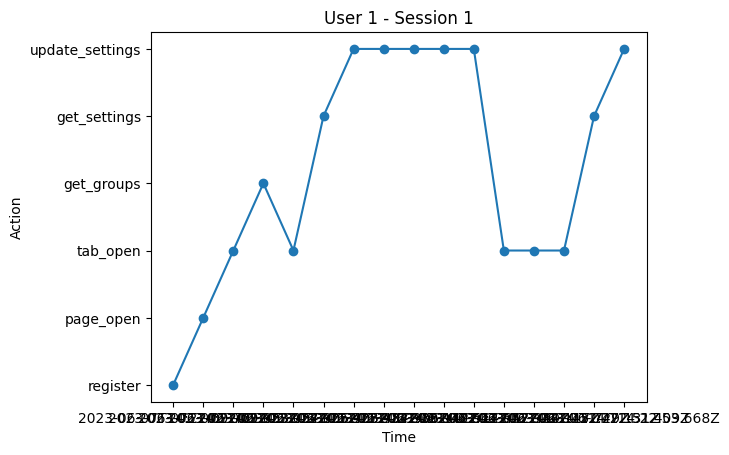

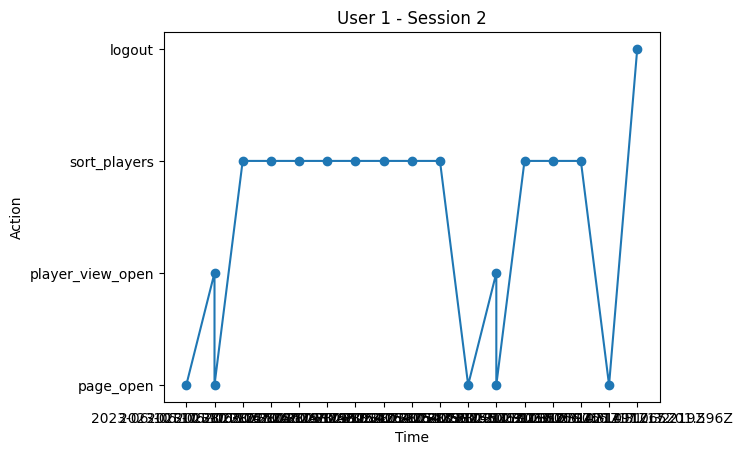

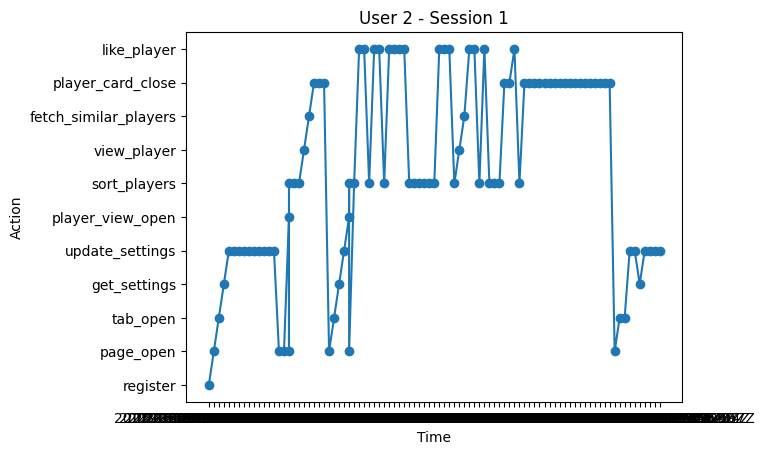

In [7]:
import matplotlib.pyplot as plt

# Split events into sessions
sessions_all = split_into_sessions(events_all[7:], 30)

# For each user
for i, sessions in enumerate(sessions_all[:2]):
    # For each session
    for j, session in enumerate(sessions[:2]):
        # Create a new figure for each session
        plt.figure()

        # Extract the timestamps and actions from the session
        timestamps = [event['timestamp'] for event in session]
        actions = [event['action'] for event in session]

        # Create a line plot with time on the x-axis and action on the y-axis
        plt.plot(timestamps, actions, marker='o')

        # Set the title and labels
        plt.title(f'User {i+1} - Session {j+1}')
        plt.xlabel('Time')
        plt.ylabel('Action')

        # Show the plot
        plt.show()


In [21]:
import plotly.graph_objects as go
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Flatten the list of sessions to get a list of all events
all_events_flat = [event for user_sessions in filtered_sessions for session in user_sessions for event in session]

# Create a list of all transitions
transitions = [(all_events_flat[i]['action'], all_events_flat[i+1]['action']) for i in range(len(all_events_flat)-1)]

# Count the frequency of each transition
transition_counts = Counter(transitions)

# Filter out transitions with a count of less than 10
transition_counts = {k: v for k, v in transition_counts.items() if v >= 30}

# Get the unique events and create a dictionary mapping events to indices
unique_events = list(set([event for transition in transitions for event in transition]))
event_to_index = {event: i for i, event in enumerate(unique_events)}

# Convert the transition counts to a format suitable for plotly
source = [event_to_index[a] for a, b in transition_counts.keys()]
target = [event_to_index[b] for a, b in transition_counts.keys()]
value = list(transition_counts.values())

# Scale the values to increase the thickness of the links
value = [v * 5 for v in value]  # Adjust the multiplier as needed

# Count the frequency of each event
event_counts = Counter([event['action'] for event in all_events_flat])

# Create a color scale based on the event frequencies
color_scale = np.interp([event_counts[event] for event in unique_events], (min(event_counts.values()), max(event_counts.values())), (0, 1))

# Convert the color scale to hexadecimal color codes
node_color = [mcolors.to_hex(plt.cm.jet(c)) for c in color_scale]  # Use the jet colormap

# Set the color of each link to match the color of the source node
link_color = [node_color[s] for s in source]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 50,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = unique_events,
      color = node_color
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = link_color
  ))])

fig.update_layout(title_text="Most Likely Event-to-Event Workflows", font_size=10)
fig.show()


# Check the following
- Most clicked events 
- Most clicked players - explore info about those players
- Most liked players - explore info about those players
- Most recommended matches maybe? 

In [2]:
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_players = event_worker.get_view_player_timestamps()
player_views = event_worker.get_player_view_open_timestamps()
event_worker.close()
print(len(view_players))
print(len(player_views))

729
746


We have more player views. However, only view_player has the player that was viewed.

**So we use the view_player.** 
- Player views: when a browsing page opens a player.
- View players: when an opened page has a player in the ID. This must have been less effective.

In [3]:
# Check view_player counts
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_counts = event_worker.count_view_player()
like_counts = event_worker.count_like_player()
event_worker.close()
len(view_counts)

45

In [4]:
view_counts

{'Daniil Medvedev': {'total': 41,
  'preferences': 1,
  'browsing': 1,
  'browsing/player': 34,
  'browsing/parameter': 5},
 'Elise Mertens': {'total': 34, 'preferences': 4, 'browsing/player': 30},
 'Tallon Griekspoor': {'total': 17,
  'browsing/player': 14,
  'browsing/parameter': 3},
 'Felix Auger-Aliassime': {'total': 12, 'browsing/player': 12},
 'Qinwen Zheng': {'total': 11, 'browsing': 1, 'browsing/player': 10},
 'Jannik Sinner': {'total': 10, 'browsing/player': 10},
 'Belinda Bencic': {'total': 8, 'browsing/player': 8},
 'Alexander Bublik': {'total': 7, 'browsing/player': 7},
 'Alex de Minaur': {'total': 6, 'browsing/player': 6},
 'Emil Ruusuvuori': {'total': 5, 'browsing/player': 5},
 'Karolina Muchova': {'total': 4, 'browsing/player': 4},
 'Bianca Andreescu': {'total': 4, 'browsing/player': 4},
 'Liudmila Samsonova': {'total': 4, 'browsing/player': 4},
 'Varvara Gracheva': {'total': 3, 'browsing': 1, 'browsing/player': 2},
 'Maxime Cressy': {'total': 3, 'browsing/player': 2, 'b

In [5]:
like_counts

{'Daniil Medvedev': {'total': 21,
  'browsing/player': 20,
  'browsing/parameter': 1},
 'Elise Mertens': {'total': 19,
  'preferences': 1,
  'browsing/player': 17,
  'browsing/parameter': 1},
 'Felix Auger-Aliassime': {'total': 15,
  'browsing/player': 10,
  'browsing/parameter': 5},
 'Alex de Minaur': {'total': 12,
  'browsing': 6,
  'browsing/player': 5,
  'browsing/parameter': 1},
 'Tallon Griekspoor': {'total': 12,
  'browsing/player': 8,
  'browsing/parameter': 4},
 'Alexander Bublik': {'total': 11, 'browsing': 7, 'browsing/player': 4},
 'Marin Cilic': {'total': 9, 'browsing/player': 5, 'browsing/parameter': 4},
 'Veronika Kudermetova': {'total': 7,
  'preferences': 2,
  'browsing/player': 4,
  'browsing/parameter': 1},
 'Victoria Azarenka': {'total': 7, 'browsing': 2, 'browsing/player': 5},
 'Qinwen Zheng': {'total': 6, 'browsing': 1, 'browsing/player': 5},
 'Milos Raonic': {'total': 6, 'browsing/player': 5, 'browsing/parameter': 1},
 'Borna Coric': {'total': 6, 'browsing/player'

## Describe player view and like counts

       total  preferences  browsing  browsing/player  browsing/parameter
count  45.00        45.00     45.00            45.00               45.00
mean    5.11         0.11      0.11             4.64                0.24
std     7.83         0.61      0.32             6.72                0.88
min     1.00         0.00      0.00             0.00                0.00
25%     2.00         0.00      0.00             2.00                0.00
50%     3.00         0.00      0.00             2.00                0.00
75%     4.00         0.00      0.00             4.00                0.00
max    41.00         4.00      1.00            34.00                5.00

Sum of all columns:
total                 230.0
preferences             5.0
browsing                5.0
browsing/player       209.0
browsing/parameter     11.0
dtype: float64


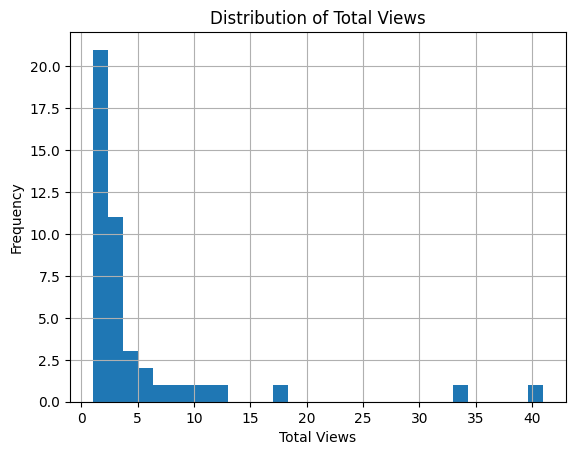

Daniil Medvedev          41.0
Elise Mertens            34.0
Tallon Griekspoor        17.0
Felix Auger-Aliassime    12.0
Qinwen Zheng             11.0
Jannik Sinner            10.0
Belinda Bencic            8.0
Alexander Bublik          7.0
Alex de Minaur            6.0
Emil Ruusuvuori           5.0
Name: total, dtype: float64


Daniil Medvedev               browsing/player
Elise Mertens                 browsing/player
Tallon Griekspoor             browsing/player
Felix Auger-Aliassime         browsing/player
Qinwen Zheng                  browsing/player
Jannik Sinner                 browsing/player
Belinda Bencic                browsing/player
Alexander Bublik              browsing/player
Alex de Minaur                browsing/player
Emil Ruusuvuori               browsing/player
Karolina Muchova              browsing/player
Bianca Andreescu              browsing/player
Liudmila Samsonova            browsing/player
Varvara Gracheva              browsing/player
Maxime Cressy                 browsing/player
Pablo Carreno Busta           browsing/player
Veronika Kudermetova          browsing/player
David Goffin                  browsing/player
Bibiane Schoofs               browsing/player
Ugo Humbert                   browsing/player
Victoria Azarenka             browsing/player
Alec Deckers                  brow

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create dictionary
data = view_counts
df = pd.DataFrame(data).T
# Convert NaN to 0
df = df.fillna(0)

# Descriptive statistics to the nearest 0.01 
print(df.describe().round(2))

# Print the sums of all columns
print("\nSum of all columns:")
print(df.sum())

# Distribution Analysis
df['total'].hist(bins=30)
plt.title('Distribution of Total Views')
plt.xlabel('Total Views')
plt.ylabel('Frequency')
plt.show()

# Top viewed players
print(df['total'].nlargest(10))

# Page from which players are viewed most
df.drop('total', axis=1).idxmax(axis=1)


In [16]:
from database_workers.Neo4j_Player_Worker import Player_Worker
player_names = list(like_counts.keys())
players = dict()

player_worker = Player_Worker()
for player in player_names:
    players[player] = player_worker.get_player_data(player)
player_worker.close()

players

{'Daniil Medvedev': {'name': 'Daniil Medvedev',
  'country': '',
  'rank': 2,
  'rank_level': 1,
  'previous_libema_winner': False,
  'status': 'Top 10',
  'experience': 3,
  'play_style': 'Counter puncher',
  'style': None,
  'age': 27,
  'height': 198,
  'favorite_shot': 'Return',
  'hand': 'Right-handed',
  'personality_tags': ['funny',
   'outspoken',
   'analytical',
   'unorthodox',
   'defensive baseliner'],
  'personality_long': "Medvedev is known for his counter-punching style and excellent defensive play. His flat and deep shots, combined with his exceptional court coverage, make him a tough player to beat. He's also known for his tactical intelligence, often adjusting his game plan mid-match to exploit his opponents' weaknesses.",
  'grass_advantage': False,
  'career_high_rank': 1,
  'years_on_tour': 9,
  'coach': 'Gilles Cervara',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/medvedev-full-2022-may.png',
  'gender': 'Male',
  'country_code': '',
  'care

In [21]:
sorted(list(players['Daniil Medvedev'].keys()))

['age',
 'career_high_rank',
 'career_high_year',
 'coach',
 'country',
 'country_code',
 'country_zone',
 'experience',
 'favorite_shot',
 'gender',
 'grass_advantage',
 'hand',
 'height',
 'image_url',
 'name',
 'personality_long',
 'personality_tags',
 'play_style',
 'previous_libema_winner',
 'rank',
 'rank_level',
 'status',
 'style',
 'years_on_tour']

## Correlation analysis

rank                     -0.210994
age                      -0.105741
height                    0.118609
career_high_rank         -0.238014
career_high_year          0.182405
years_on_tour            -0.084610
grass_advantage          -0.123954
previous_libema_winner   -0.138465
Name: total, dtype: float64

career_high_rank          0.238014
rank                      0.210994
career_high_year          0.182405
previous_libema_winner    0.138465
grass_advantage           0.123954
height                    0.118609
age                       0.105741
years_on_tour             0.084610
Name: total, dtype: float64


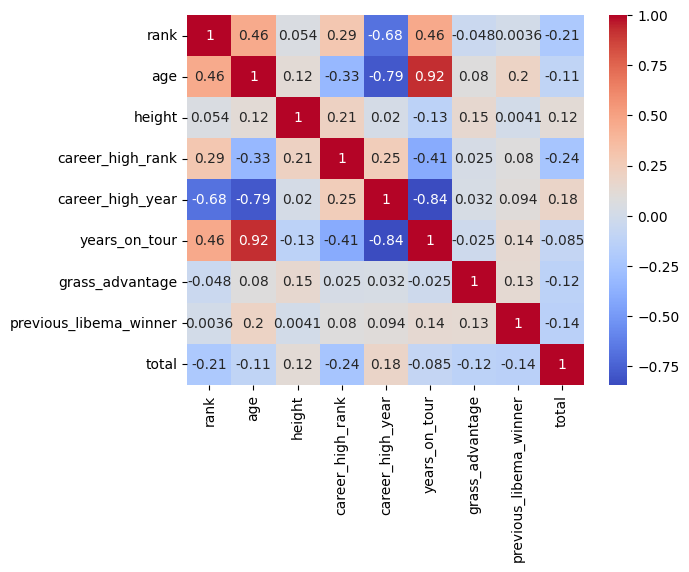

In [30]:
# Convert dictionaries to pandas DataFrames
view_df_numeric = pd.DataFrame(view_counts).T
player_df_numeric = pd.DataFrame(players).T

# Drop non_numeric columns
view_df_numeric = view_df_numeric.drop(['browsing'], axis=1)
player_df_numeric = player_df_numeric[['rank', 'age', 'height', 'career_high_rank', 'career_high_year', 'years_on_tour', 'grass_advantage', 'previous_libema_winner']]
player_df_numeric['previous_libema_winner'] = player_df_numeric['previous_libema_winner'].astype(int)


# Replace NaN with 0
view_df_numeric = view_df_numeric.fillna(0)
player_df_numeric = player_df_numeric.fillna(0)


# Merge the two dataframes on the index (player name)
df = pd.merge(player_df_numeric, view_df_numeric['total'], left_index=True, right_index=True)

# Convert columns to appropriate data types
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Calculate correlation matrix
correlation_matrix = df.corr()

print(correlation_matrix['total'][:-1])

# Now print them in order of overall magnitude (turn them all positive), from highest to lowest, , excluding the last one (which is the total itself)
print()
print(correlation_matrix['total'][:-1].abs().sort_values(ascending=False))

# Plot the correlation matrix
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


# To do
For categorical variables, you could perform an ANOVA or Chi-squared test to determine if the variable is associated with total views.

## Some other stuff


In [32]:
# Function to get info about characteristic of players
import pandas as pd

# Convert dictionaries to pandas DataFrames
player_df = pd.DataFrame(players).T
view_df = pd.DataFrame(view_counts).T
like_df = pd.DataFrame(like_counts).T


def analyze_data(action, property):
    # Merge the two dataframes on the index (player name)
    df = pd.merge(player_df, view_df if action == "view" else like_df, left_index=True, right_index=True)

    # return df
    # Calculate descriptive statistics
    action_count = df["total"].count()
    action_mean = df["total"].mean()
    action_std_dev = df["total"].std()
    action_min_value = df["total"].min()
    action_max_value = df["total"].max()

    property_count = df[property].count()
    property_mean = df[property].mean()
    property_std_dev = df[property].std()
    property_min_value = df[property].min()
    property_max_value = df[property].max()

    print(f"{action} Count: {action_count}")
    print(f"{action} Mean: {action_mean}")
    print(f"{action} Standard Deviation: {action_std_dev}")
    print(f"{action} Minimum: {action_min_value}")
    print(f"{action} Maximum: {action_max_value}\n")
    
    print(f"{property} Mean: {property_mean}")
    print(f"{property} Standard Deviation: {property_std_dev}")
    print(f"{property} Minimum: {property_min_value}")
    print(f"{property} Maximum: {property_max_value}")

In [33]:
analyze_data("view", "rank")

view Count: 36
view Mean: 5.138888888888889
view Standard Deviation: 7.3256994898694145
view Minimum: 1.0
view Maximum: 36.0

rank Mean: 66.27777777777777
rank Standard Deviation: 119.35603668044398
rank Minimum: 2
rank Maximum: 696


In [3]:
from datetime import datetime

def sort_timestamps(timestamp_strings):
    # Convert strings to datetime objects
    timestamps = [datetime.strptime(ts, "%Y-%m-%dT%H:%M:%S.%fZ") for ts in timestamp_strings]

    # Sort the timestamps
    sorted_timestamps = sorted(timestamps)

    # Convert datetime objects back to strings
    sorted_timestamp_strings = [datetime.strftime(ts, "%Y-%m-%dT%H:%M:%S.%fZ") for ts in sorted_timestamps]
    
    return sorted_timestamp_strings

In [6]:
sorted_view_players = sort_timestamps(view_players)
sorted_player_views = sort_timestamps(player_views)

print(sorted_view_players[-1])
print(sorted_player_views[-1])

2023-07-23T19:53:57.032000Z
2023-07-24T09:16:23.051000Z


# User session plots and stuff

user
0dGe53JeTjeq12tbkXcdUEj9dDI3            NaN
3A9DsPaAqKSgx8lCRY9yUAJh7qJ2       1.133734
4omSE8c3AcS2nBxWDBtyTa1HfFC2       0.066965
7ExaQlo10JbHZH22TVf3PLU7wkD2       0.033157
9VTIpztA0nVDMeNrsEist6eocn62    5540.374365
AN57y8tcIThEeqeo9Uq1s7pHzM03     528.018997
CMgYGM87zOWEcwyL11Ub6vKg2vs2      38.804700
Eh6s0pJOXiYYhwq93HW5TqFGWlj1       0.335209
FyPkd36scVfQCNDtVxPenj2TDGv2       1.350296
H6zWuaCdqGTDaiwcxRzXNSkCd972       0.212808
IePsL61S1EPJsEr2FofOzAHdb8N2     772.609997
KLZv1337CHhDrlkVATeAIq5EyEl1       1.003742
KU10LuGLDphhAnIQdCep4CiNckL2       0.048326
KtF5P5AkqOXzE2rmyR51dotzeDk2      88.343943
MMt8Hfb63xhuX4lq2tMyUNFZKLD2     427.653618
NXQXBvqF4GMYK6w4L4ftDFo1gKn2      58.556026
Nhl8tciip6bnePX87rmt8jOU23p1       1.247907
NrxmjETU4Cd2SvWcrANRMz6qOMC3     341.343905
PEmVuwqDEKRY1VL9Kv8nqnsAKc32       1.672264
Q0Lltr3O9dZTwYvjITSXR0fU5Kp1      65.123782
V7bQoGcuYwWp31ZeAEjsVqNA4xp2       3.532477
Wi9PA6BUUnWK3HHGs3fsCB6ciAm1       3.590548
XFspFzuILdX4PWJuSyzTEE1LdGm

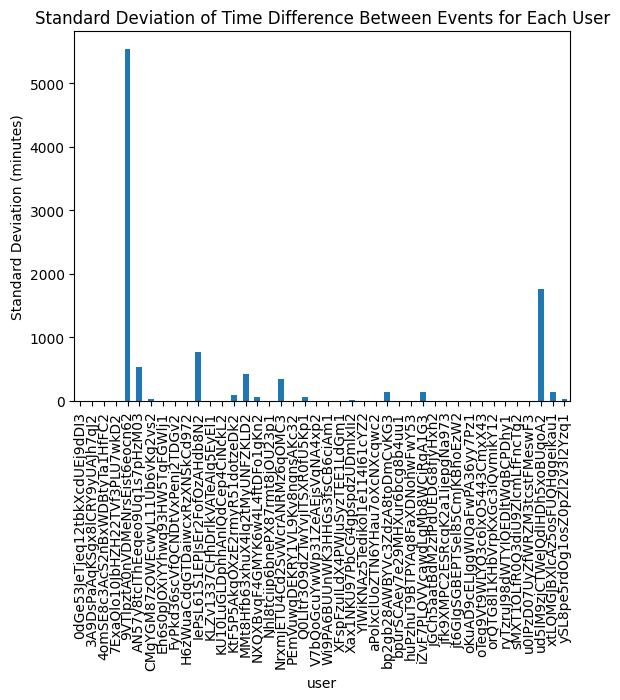

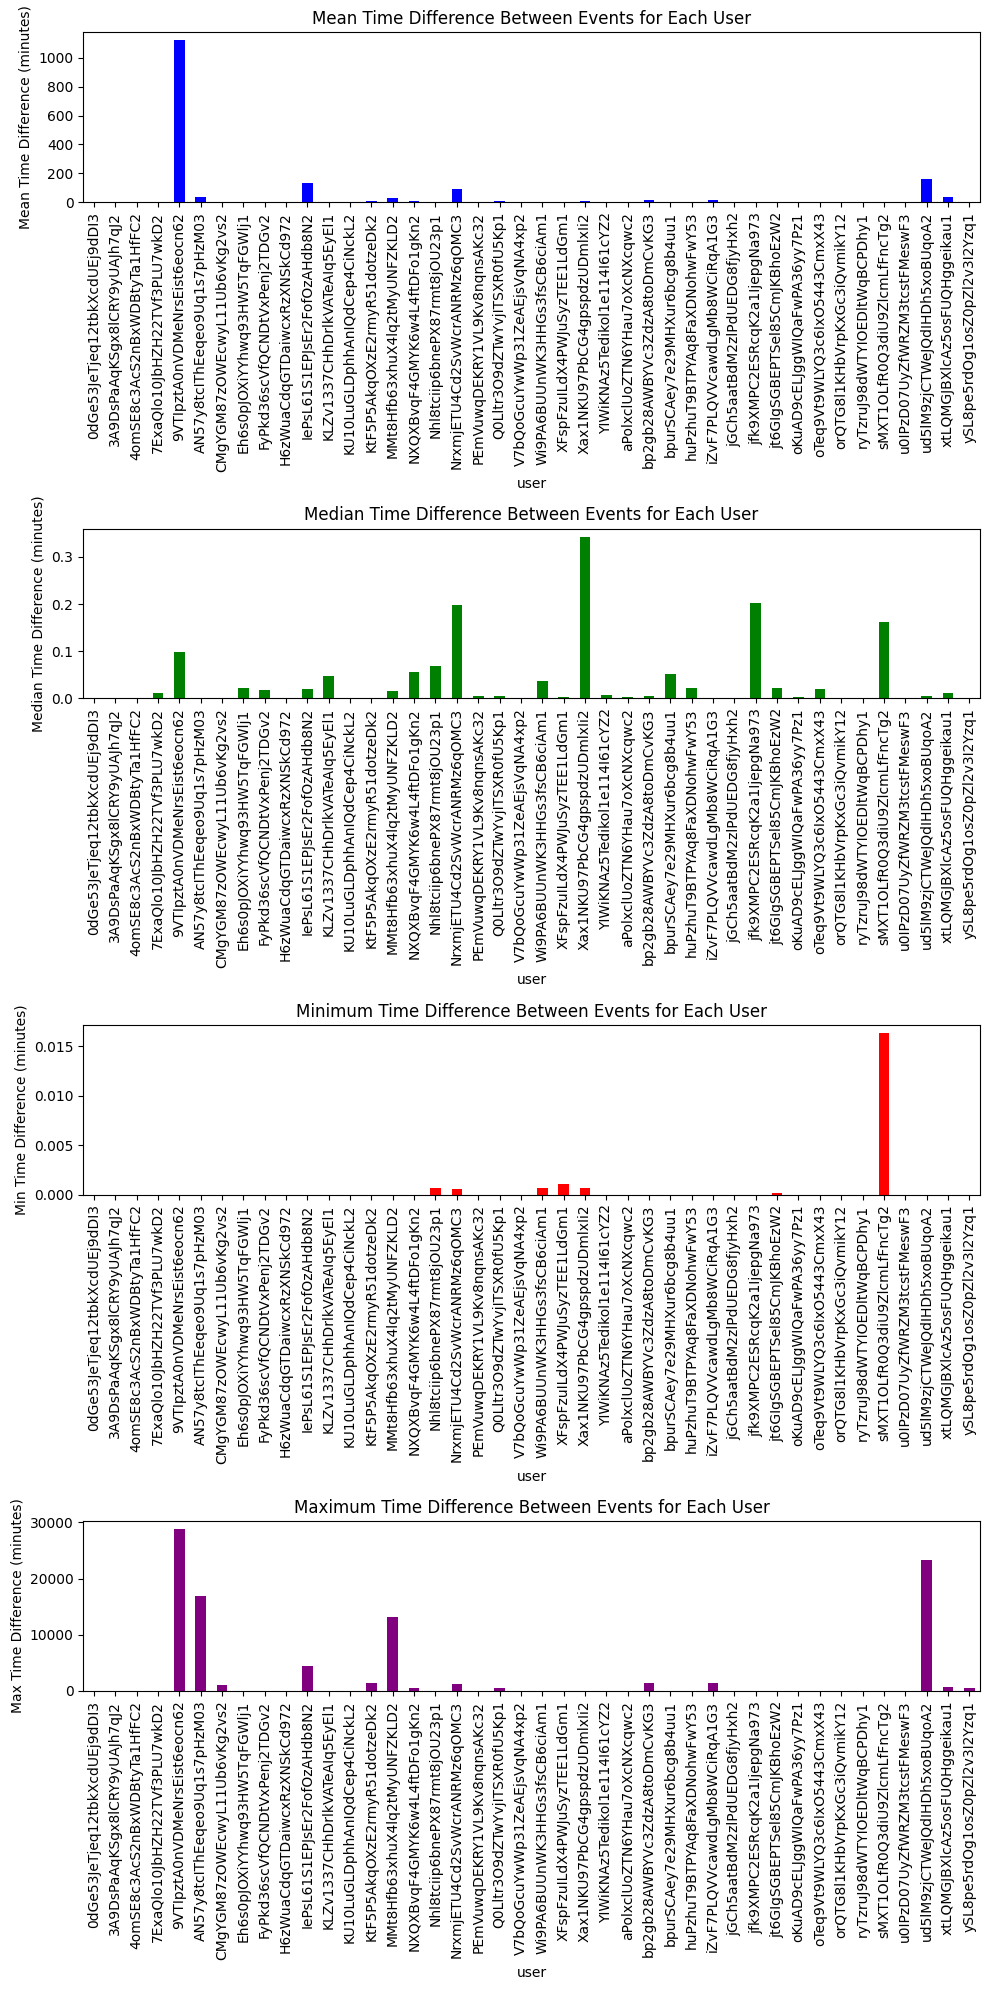

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Assuming events is your list of lists of events
# Convert it into a pandas DataFrame for easier manipulation
df = pd.DataFrame([event for user_events in events_all for event in user_events])

# Convert timestamp to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp
df = df.sort_values('timestamp')

# Calculate time difference between consecutive events
df['time_diff'] = df.groupby('user')['timestamp'].diff()

# Convert time difference to minutes
df['time_diff'] = df['time_diff'].dt.total_seconds() / 60

# Create 5-minute bins
bins = pd.interval_range(start=0, freq=5, end=df['time_diff'].max())
df['time_diff_bin'] = pd.cut(df['time_diff'], bins=bins)

# Calculate standard deviation for each user
std_devs = df.groupby('user')['time_diff'].std()
mean_diffs = df.groupby('user')['time_diff'].mean()
median_diffs = df.groupby('user')['time_diff'].median()
min_diffs = df.groupby('user')['time_diff'].min()
max_diffs = df.groupby('user')['time_diff'].max()

# Print standard deviations
print(std_devs)
print("Mean time differences:\n", mean_diffs)
print("Median time differences:\n", median_diffs)
print("Minimum time differences:\n", min_diffs)
print("Maximum time differences:\n", max_diffs)

# Plot standard deviations
std_devs.plot(kind='bar')
plt.ylabel('Standard Deviation (minutes)')
plt.title('Standard Deviation of Time Difference Between Events for Each User')
plt.show()

# Plot mean, median, min, and max time differences
fig, axs = plt.subplots(4, figsize=(10,20))

mean_diffs.plot(kind='bar', ax=axs[0], color='blue')
axs[0].set_ylabel('Mean Time Difference (minutes)')
axs[0].set_title('Mean Time Difference Between Events for Each User')

median_diffs.plot(kind='bar', ax=axs[1], color='green')
axs[1].set_ylabel('Median Time Difference (minutes)')
axs[1].set_title('Median Time Difference Between Events for Each User')

min_diffs.plot(kind='bar', ax=axs[2], color='red')
axs[2].set_ylabel('Min Time Difference (minutes)')
axs[2].set_title('Minimum Time Difference Between Events for Each User')

max_diffs.plot(kind='bar', ax=axs[3], color='purple')
axs[3].set_ylabel('Max Time Difference (minutes)')
axs[3].set_title('Maximum Time Difference Between Events for Each User')

plt.tight_layout()
plt.show()


                                      count       mean    median       min   
user                         session                                         
0dGe53JeTjeq12tbkXcdUEj9dDI3 61           0        NaN       NaN       NaN  \
3A9DsPaAqKSgx8lCRY9yUAJh7qJ2 46          25   0.282450  0.001050  0.000000   
4omSE8c3AcS2nBxWDBtyTa1HfFC2 63           6   0.030089  0.001083  0.000000   
7ExaQlo10JbHZH22TVf3PLU7wkD2 13          94   0.023070  0.010642  0.000000   
9VTIpztA0nVDMeNrsEist6eocn62 92          16   1.655683  0.050975  0.000000   
...                                     ...        ...       ...       ...   
ySL8pe5rdOg1osZ0pZl2v3I2Yzq1 101          6  33.806286  0.322400  0.000017   
                             102          9   2.564006  0.225033  0.000000   
                             103         69   0.533009  0.001467  0.000000   
                             104          7   9.599110  0.000517  0.000000   
                             105         28   3.252562  0.000300

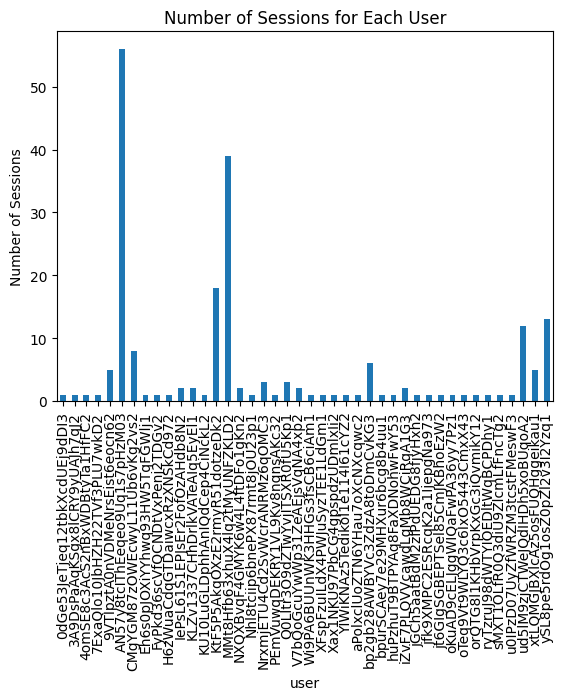

In [ ]:
# Define a session as a series of events that are separated by no more than 30 minutes of inactivity
session_threshold = 30  # minutes

# Add a new column that indicates the session each event belongs to
df['session'] = (df['time_diff'] > session_threshold).cumsum()

# Calculate statistics for each session
session_stats = df.groupby(['user', 'session'])['time_diff'].agg(['count', 'mean', 'median', 'min', 'max', 'std'])

# Print session statistics
print(session_stats)

# Calculate the number of sessions for each user
num_sessions = df.groupby('user')['session'].nunique()

# Print the number of sessions for each user
print(num_sessions)

# Plot the number of sessions for each user
num_sessions.plot(kind='bar')
plt.ylabel('Number of Sessions')
plt.title('Number of Sessions for Each User')
plt.show()


In [ ]:
# order numsessions
num_sessions = num_sessions.sort_values(ascending=False)
num_sessions

user
AN57y8tcIThEeqeo9Uq1s7pHzM03    56
MMt8Hfb63xhuX4lq2tMyUNFZKLD2    39
KtF5P5AkqOXzE2rmyR51dotzeDk2    18
ySL8pe5rdOg1osZ0pZl2v3I2Yzq1    13
ud5lM9zjCTWeJQdIHDh5xoBUqoA2    12
CMgYGM87zOWEcwyL11Ub6vKg2vs2     8
bp2gb28AWBYVc3ZdzA8toDmCvKG3     6
xtLQMGJBXlcAz5osFUQHggeikau1     5
9VTIpztA0nVDMeNrsEist6eocn62     5
NrxmjETU4Cd2SvWcrANRMz6qOMC3     3
Q0Lltr3O9dZTwYvjITSXR0fU5Kp1     3
NXQXBvqF4GMYK6w4L4ftDFo1gKn2     2
V7bQoGcuYwWp31ZeAEjsVqNA4xp2     2
KLZv1337CHhDrlkVATeAIq5EyEl1     2
iZvF7PLQVVcawdLgMb8WCiRqA1G3     2
IePsL61S1EPJsEr2FofOzAHdb8N2     2
huPzhuT9BTPYAq8FaXDNohwFwY53     1
jGCh5aatBdM2zlPdUEDG8fjyHxh2     1
jfk9XMPC2ESRcqK2a1IjepgNa973     1
jt6GIgSGBEPTSel85CmJKBhoEzW2     1
ryTzruJ98dWTYIOEDltWqBCPDhy1     1
oTeq9Vt9WLYQ3c6IxO5443CmxX43     1
u0IPzD07UyZfWRZM3tcstFMeswF3     1
sMXT1OLfR0Q3diU9ZlcmLfFncTg2     1
bpurSCAey7e29MHXur6bcg8b4uu1     1
orQTG8l1KHbVrpKxGc3iQvmikY12     1
oKuAD9cELJggWIQaFwPA36yy7Pz1     1
0dGe53JeTjeq12tbkXcdUEj9dDI3     1
aPolxclUoZTN6YH

In [ ]:
# Get username based on user id
from database_workers.Neo4j_User_Worker import User_Worker
user_worker = User_Worker()
usernames = []
for user in num_sessions[:12].index:
    usernames.append(user_worker.get_username(user))
user_worker.close()

# And attach the username to the number of sessions
num_sessions = pd.DataFrame({'username': usernames, 'num_sessions': num_sessions[:12].values})
num_sessions

,username,num_sessions
0,Asaf,56
1,McW,39
2,Koen,18
3,Kees,13
4,Asaf Tester,12
5,Gergő,8
6,Linda Derksen,6
7,Test136,5
8,Martijn,5
9,None,3
